## TrOCR finetunning for Hindi OCR dataset
In this notebook we are going to use [TrOCR: Transformer-based Optical Character Recognition with Pre-trained Models](https://arxiv.org/abs/2109.10282)  for [Hindi OCR synthetic line image-text pair](https://www.kaggle.com/datasets/prathmeshzade/hindi-ocr-synthetic-line-image-text-pair/data) dataset.

Special thanks to [Niels Rogge](https://github.com/NielsRogge/Transformers-Tutorials/tree/master/TrOCR) works for making it's implementation easier 😇.

TrOCR architecture
![Architecture](https://camo.githubusercontent.com/ea6f808ea48f4cd643faa93dbc32474f6e62a45ac3bc41c4ac6f7b413f86dd8e/68747470733a2f2f7062732e7477696d672e636f6d2f6d656469612f46414464545845566741417354574c3f666f726d61743d6a7067266e616d653d343039367834303936)

## Installing dependencies ⚙️

In [1]:
!pip install -q evaluate datasets jiwer transformers accelerate wandb

## Checking for gpu 🧐

In [2]:
!nvidia-smi

Tue Apr  9 09:15:22 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.129.03             Driver Version: 535.129.03   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla P100-PCIE-16GB           Off | 00000000:00:04.0 Off |                    0 |
| N/A   33C    P0              25W / 250W |      0MiB / 16384MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [3]:
import torch
torch.__version__

'2.1.2'

In [4]:
# check if cuda is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

Using device: cuda


## Dataset overview and preprocessing 🔄

In [5]:
import os
import pandas as pd

df=pd.read_csv('/kaggle/input/hindi-ocr-synthetic-line-image-text-pair/data_80k/data.csv')
df.head()

,image_file,text,font_size,font_file,word_count
0,1.png,गर्भनिरोध के लिए महिलाएं क्यों कराती हैं नसबंदी,51,Lohit-Devanagari.ttf,8
1,2.png,'मस्‍ज‍िद ख़ुदा का घर है तो यह ईमान वाली स्‍त्...,31,Lohit-Devanagari.ttf,17
2,3.png,"नज़रिया: गोरखपुर, नागपुर और दिल्ली के त्रिकोण ...",39,Sura-Regular.ttf,11
3,4.png,अनुच्छेद 370 के बाद क्या हो सकता है मोदी सरकार...,35,arial-unicode-ms.ttf,13
4,5.png,इराक़ में तीन अमरीकी सैनिक मारे गए,58,NotoSansDevanagari.ttf,7


In [6]:
# split data into train and test
train_df = df[:int(len(df)*0.9)]
test_df = df[int(len(df)*0.9):]
print(f'length of df: {len(df)},  train_df: {len(train_df)}, test_df: {len(test_df)}')

length of df: 80000,  train_df: 72000, test_df: 8000


In [7]:
from torchvision.transforms import v2
from PIL import Image
import matplotlib.pyplot as plt
from torchvision.transforms.functional import InterpolationMode
# define transforms we are going to use RandomPerspective for our ocr model
# we are using transforms to avoid overfitting and to make our model more robust

train_transform = transforms = v2.Compose([
    v2.ElasticTransform(alpha=8.0, sigma=5.0, interpolation=InterpolationMode.BILINEAR, fill=0),
    v2.GaussianBlur(kernel_size=(5, 9), sigma=(0.1, 5.)),
    v2.Resize((384,384)),
    v2.ToTensor(),
    v2.Normalize([0.5,0.5,0.5], [0.5,0.5,0.5]),
])

eval_transform = transforms = v2.Compose([
    # v2.Pad([80,364], padding_mode='constant', fill=244),
    v2.Resize((384,384)),
    v2.ToTensor(),
    v2.Normalize([0.5,0.5,0.5], [0.5,0.5,0.5]),
])

img=Image.open('/kaggle/input/hindi-ocr-synthetic-line-image-text-pair/data_80k/output_images/1.png')

/opt/conda/lib/python3.10/site-packages/torchvision/transforms/v2/_deprecated.py:43: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.
  warnings.warn(


**I tried different data augmentation techniques, have a look at** [this sheet](https://docs.google.com/spreadsheets/d/1bhlofeyP94hiB_cd41ZTV_ncHr3q00usY1mAyW-XcLM/edit?usp=sharing)

In [8]:
from torch.utils.data import Dataset, DataLoader
from tqdm.notebook import tqdm
import torch.optim as optim

class OCRdataset(Dataset):
    def __init__(self, root_dir, df, processor, max_target_length=64, transforms=None):
        self.root_dir = root_dir
        self.df = df
        self.processor = processor
        self.max_target_length = max_target_length
        self.transforms = transforms

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        # reset df index
        self.df = self.df.reset_index(drop=True)

        # get file name + text
        file_name = self.df['image_file'][idx]
        text = self.df['text'][idx]

        # prepare image (i.e. resize + normalize)
        image = Image.open(self.root_dir + file_name).convert("RGB")
        
        pixel_values=self.transforms(image)
        # if you don't want to use the transforms, you can also uncomment the following code and comment the above two lines
        # make sure to uncomment the transforms in the __init__ method as well
        # pixel_values = self.processor(image, return_tensors="pt").pixel_values

        # add labels (input_ids) by encoding the text
        labels = self.processor.tokenizer(text,
                                          padding="max_length",
                                          truncation=True,
                                          max_length=self.max_target_length).input_ids

        # important: make sure that PAD tokens are ignored by the loss function
        labels = [label if label != self.processor.tokenizer.pad_token_id else -100 for label in labels]

        encoding = {"pixel_values": pixel_values, "labels": torch.tensor(labels)}
        return encoding

print("done")

done


In [9]:
from transformers import DeiTImageProcessor, BertTokenizer, TrOCRProcessor,VisionEncoderDecoderModel

tokenizer = BertTokenizer.from_pretrained("bert-base-multilingual-cased")
image_processor=DeiTImageProcessor.from_pretrained("facebook/deit-base-distilled-patch16-384")
processor = TrOCRProcessor(image_processor = image_processor, tokenizer = tokenizer)

# processor = TrOCRProcessor.from_pretrained("microsoft/trocr-base-handwritten")

train_dataset = OCRdataset(root_dir='/kaggle/input/hindi-ocr-synthetic-line-image-text-pair/data_80k/output_images/',
                           df=train_df,
                           processor=processor,
                          transforms=train_transform)

eval_dataset = OCRdataset(root_dir='/kaggle/input/hindi-ocr-synthetic-line-image-text-pair/data_80k/output_images/',
                           df=test_df,
                           processor=processor,
                         transforms=eval_transform)

2024-04-09 09:15:31.797503: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-09 09:15:31.797638: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-09 09:15:31.936167: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/996k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.96M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/625 [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/287 [00:00<?, ?B/s]

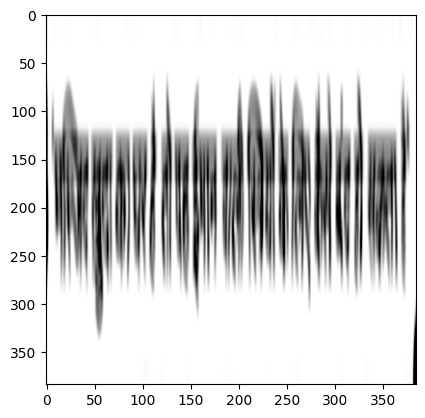

In [10]:
# check dataset image
img_tensor = train_dataset[1]['pixel_values']
plt.imshow(img_tensor.permute(1,2,0))

In [11]:
print("Number of training examples:", len(train_dataset))
print("Number of validation examples:", len(eval_dataset))

Number of training examples: 72000
Number of validation examples: 8000


In [12]:
# check the first example for train_dataset
encoding = train_dataset[0]
for k,v in encoding.items():
  print(k, v.shape)
print('\n')

# check the first example for eval_dataset
encode = eval_dataset[0]
for k,v in encode.items():
  print(k, v.shape)

pixel_values torch.Size([3, 384, 384])
labels torch.Size([64])


pixel_values torch.Size([3, 384, 384])
labels torch.Size([64])


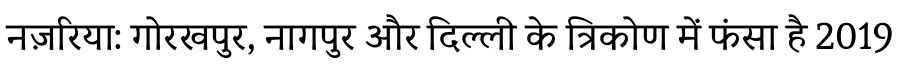

In [13]:
# checking the example for train_dataset
# Image
encoding=train_dataset[2]
image = Image.open(train_dataset.root_dir + df['image_file'][2]).convert("RGB")
image

In [14]:
# Labels
labels = encoding['labels']
labels[labels == -100] = processor.tokenizer.pad_token_id
label_str = processor.decode(labels, skip_special_tokens=True)
print(label_str)

नज़रिया : गोरखपुर, नागपुर और दिल्ली के त्रिकोण में फंसा है 2019


# Defining TrOCR model architecture 📝

In [15]:
# initialize the encoder from a pretrained ViT and the decoder from a pretrained BERT model.
# Note that the cross-attention layers will be randomly initialized, and need to be fine-tuned on a downstream dataset
model = VisionEncoderDecoderModel.from_encoder_decoder_pretrained("facebook/deit-base-distilled-patch16-384", "bert-base-multilingual-cased")
print(model.config.decoder.decoder_start_token_id)
model.to(device)

config.json:   0%|          | 0.00/69.6k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/351M [00:00<?, ?B/s]

Some weights of DeiTModel were not initialized from the model checkpoint at facebook/deit-base-distilled-patch16-384 and are newly initialized: ['deit.pooler.dense.bias', 'deit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


model.safetensors:   0%|          | 0.00/714M [00:00<?, ?B/s]

Some weights of BertLMHeadModel were not initialized from the model checkpoint at bert-base-multilingual-cased and are newly initialized: ['bert.encoder.layer.0.crossattention.output.LayerNorm.bias', 'bert.encoder.layer.0.crossattention.output.LayerNorm.weight', 'bert.encoder.layer.0.crossattention.output.dense.bias', 'bert.encoder.layer.0.crossattention.output.dense.weight', 'bert.encoder.layer.0.crossattention.self.key.bias', 'bert.encoder.layer.0.crossattention.self.key.weight', 'bert.encoder.layer.0.crossattention.self.query.bias', 'bert.encoder.layer.0.crossattention.self.query.weight', 'bert.encoder.layer.0.crossattention.self.value.bias', 'bert.encoder.layer.0.crossattention.self.value.weight', 'bert.encoder.layer.1.crossattention.output.LayerNorm.bias', 'bert.encoder.layer.1.crossattention.output.LayerNorm.weight', 'bert.encoder.layer.1.crossattention.output.dense.bias', 'bert.encoder.layer.1.crossattention.output.dense.weight', 'bert.encoder.layer.1.crossattention.self.key.bia

None


VisionEncoderDecoderModel(
  (encoder): DeiTModel(
    (embeddings): DeiTEmbeddings(
      (patch_embeddings): DeiTPatchEmbeddings(
        (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): DeiTEncoder(
      (layer): ModuleList(
        (0-11): 12 x DeiTLayer(
          (attention): DeiTAttention(
            (attention): DeiTSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
            (output): DeiTSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (intermediate): DeiTIntermediate(
            (dense): Linear(

In [16]:
# set special tokens used for creating the decoder_input_ids from the labels
model.config.decoder_start_token_id = processor.tokenizer.cls_token_id
model.config.pad_token_id = processor.tokenizer.pad_token_id

# make sure vocab size is set correctly
model.config.vocab_size = model.config.decoder.vocab_size

# set beam search parameters
model.config.eos_token_id = processor.tokenizer.sep_token_id
model.config.max_length = 64
model.config.early_stopping = True
model.config.no_repeat_ngram_size = 3
model.config.length_penalty = 2.0
model.config.num_beams = 4

In [17]:
# defining our loss metrics
# from datasets import load_metric #(optional method)
from evaluate import load
cer_metric = load("cer")
wer_metric = load("wer")
# accuracy_metric = load("accuracy")

def compute_metrics(pred):
    labels_ids = pred.label_ids
    pred_ids = pred.predictions

    pred_str = processor.batch_decode(pred_ids, skip_special_tokens=True)
    labels_ids[labels_ids == -100] = processor.tokenizer.pad_token_id
    label_str = processor.batch_decode(labels_ids, skip_special_tokens=True)

    cer = cer_metric.compute(predictions=pred_str, references=label_str)
    wer = wer_metric.compute(predictions=pred_str, references=label_str)
    # accuracy = accuracy_metric.compute(predictions=pred_str, references=label_str)

    return {"cer": cer, "wer": wer}

In [23]:
from transformers import Seq2SeqTrainer, Seq2SeqTrainingArguments

training_args = Seq2SeqTrainingArguments(
    predict_with_generate=True,
    evaluation_strategy="steps",
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=7,
    fp16=True,
    fp16_full_eval=True,
#     dataloader_pin_memory=False,
#     optim="adamw_torch_fused",
#     dataloader_num_workers=4,
#     ddp_backend="nccl", # gloo cause we are using tpu, use nccl for gpu
#     fsdp="full_shard",
#     fsdp_config=fsdp_config,
#     torch_compile=True,
#     split_batches=4,
#     dataloader_persistent_workers=True,
    report_to="wandb",
    learning_rate=4e-5,
    output_dir="./",
    logging_dir="./logs",
    logging_strategy="steps",
    logging_steps=10,
    save_strategy="steps",
    resume_from_checkpoint=True,
    save_steps=8000,
    eval_steps=8000,
)


In [24]:
from transformers import default_data_collator
    
# instantiate trainer
trainer = Seq2SeqTrainer(
    model=model,
    tokenizer=processor.tokenizer,
    args=training_args,
    compute_metrics=compute_metrics,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
    data_collator=default_data_collator,
)
trainer.train("checkpoint-56000")
#trainer.save_model('./model')

There were missing keys in the checkpoint model loaded: ['decoder.cls.predictions.decoder.weight', 'decoder.cls.predictions.decoder.bias'].
wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

  ········································


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


We strongly recommend passing in an `attention_mask` since your input_ids may be padded. See https://huggingface.co/docs/transformers/troubleshooting#incorrect-output-when-padding-tokens-arent-masked.


Step,Training Loss,Validation Loss


TrainOutput(global_step=63000, training_loss=0.0026223275619485075, metrics={'train_runtime': 8057.6177, 'train_samples_per_second': 62.55, 'train_steps_per_second': 7.819, 'total_flos': 2.686372809647063e+20, 'train_loss': 0.0026223275619485075, 'epoch': 7.0})

In [25]:
trainer.save_model('./model')

Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'max_length': 64, 'early_stopping': True, 'num_beams': 4, 'length_penalty': 2.0, 'no_repeat_ngram_size': 3}
Removed shared tensor {'decoder.cls.predictions.decoder.bias', 'decoder.cls.predictions.decoder.weight'} while saving. This should be OK, but check by verifying that you don't receive any warning while reloading


## Inference on test sample single image ✍️

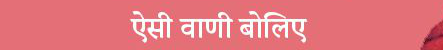

In [20]:
import requests
from io import StringIO
img=Image.open("/kaggle/input/hindi-ocr-synthetic-line-image-text-pair/data_80k/TestSamples/1.png").convert("RGB")
img

In [26]:
import torch
import torchvision.transforms as v2
model = VisionEncoderDecoderModel.from_pretrained("/kaggle/working/model")
# device = torch.device('cpu')
model= model.to(device)
model.eval()
transform = v2.Compose([
    v2.Resize((384,384)),
    v2.ToTensor(),
    v2.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5]),
])
img_t = transform(img).unsqueeze(0)
# p = processor(img, return_tensors="pt").pixel_values
p= img_t.to(device)

generated_ids = model.generate(p)
generated_text = processor.batch_decode(generated_ids, skip_special_tokens=True)[0]
print(generated_text)
print(generated_ids)

जहां'बापू'के कहने पर लौट आए थे मुसलमान...
tensor([[  101,   101,   101, 79186,   112,   887, 89150, 15778,   112, 10412,
           865, 43486, 11554, 12213,   893, 78530, 14835,   852, 22599, 17798,
           889, 14070, 13432, 11714, 32742,   119,   119,   119,   102]],
       device='cuda:0')


## Inference on train images ✍️

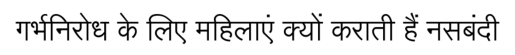

Image: /kaggle/input/hindi-ocr-synthetic-line-image-text-pair/data_80k/output_images/1.png
Generated Text: गर्भनिरोध के लिए महिलाएं क्यों कराती हैं नसबंदी
-------------------------xxxx-------------------------


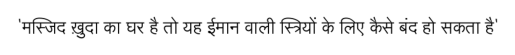

Image: /kaggle/input/hindi-ocr-synthetic-line-image-text-pair/data_80k/output_images/2.png
Generated Text: ' मस्जिद ख़ुदा का घर है तो यह ईमान वाली स्त्रियों के लिए कैसे बंद हो सकता है '
-------------------------xxxx-------------------------


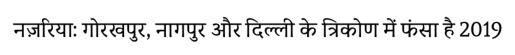

Image: /kaggle/input/hindi-ocr-synthetic-line-image-text-pair/data_80k/output_images/3.png
Generated Text: नज़रिया : गोरखपुर, नागपुर और दिल्ली के त्रिकोण में फंसा है 2019
-------------------------xxxx-------------------------


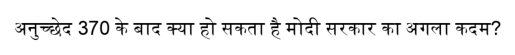

Image: /kaggle/input/hindi-ocr-synthetic-line-image-text-pair/data_80k/output_images/4.png
Generated Text: अनुच्छेद 370 के बाद क्या हो सकता है मोदी सरकार का अगला कदम?
-------------------------xxxx-------------------------


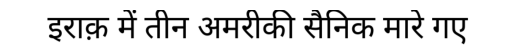

Image: /kaggle/input/hindi-ocr-synthetic-line-image-text-pair/data_80k/output_images/5.png
Generated Text: इराक़ में तीन अमरीकी सैनिक मारे गए
-------------------------xxxx-------------------------


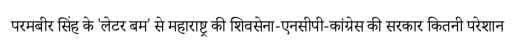

Image: /kaggle/input/hindi-ocr-synthetic-line-image-text-pair/data_80k/output_images/6.png
Generated Text: परमबीर सिंह के'लेटर बम'से महाराष्ट्र की गिवसेना - एनसीपी - कांग्रेस की सरकार कितनी परेशान
-------------------------xxxx-------------------------


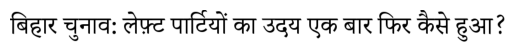

Image: /kaggle/input/hindi-ocr-synthetic-line-image-text-pair/data_80k/output_images/7.png
Generated Text: बिहार चुनाव : लेफ़्ट पार्टियों का उदय एक बार फिर कैसे हुआ?
-------------------------xxxx-------------------------


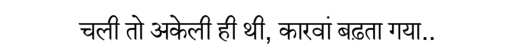

Image: /kaggle/input/hindi-ocr-synthetic-line-image-text-pair/data_80k/output_images/8.png
Generated Text: चली तो अकेली ही थी, कारवां बढ़ता गया..
-------------------------xxxx-------------------------


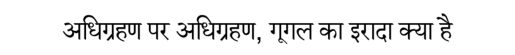

Image: /kaggle/input/hindi-ocr-synthetic-line-image-text-pair/data_80k/output_images/9.png
Generated Text: अधिग्रहण पर अभिग्रहण, गूगल का इरादा क्या है
-------------------------xxxx-------------------------


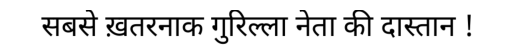

Image: /kaggle/input/hindi-ocr-synthetic-line-image-text-pair/data_80k/output_images/10.png
Generated Text: सबसे ख़तरनाक गुरिल्ला नेता की दास्तान!
-------------------------xxxx-------------------------


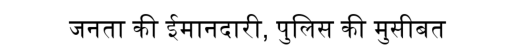

Image: /kaggle/input/hindi-ocr-synthetic-line-image-text-pair/data_80k/output_images/11.png
Generated Text: जनता की ईमानदारी, पुलिस की मुसीबत
-------------------------xxxx-------------------------


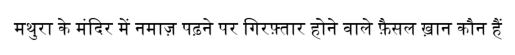

Image: /kaggle/input/hindi-ocr-synthetic-line-image-text-pair/data_80k/output_images/12.png
Generated Text: मथुरा के मंदिर में नमाज़ पढ़ने पर गिरफ़्तार होने वाले फ़ैसल ख़ान कौन हैं
-------------------------xxxx-------------------------


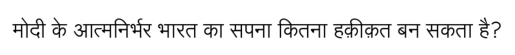

Image: /kaggle/input/hindi-ocr-synthetic-line-image-text-pair/data_80k/output_images/13.png
Generated Text: मोदी के आत्मनिर्भर भारत का सपना कितना हक़ीक़त बन सकता है?
-------------------------xxxx-------------------------


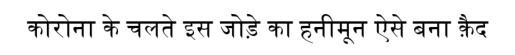

Image: /kaggle/input/hindi-ocr-synthetic-line-image-text-pair/data_80k/output_images/14.png
Generated Text: कोरोना के चलते इस जोड़े का हनीमून ऐसे बना क़ैद
-------------------------xxxx-------------------------


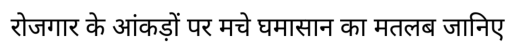

Image: /kaggle/input/hindi-ocr-synthetic-line-image-text-pair/data_80k/output_images/15.png
Generated Text: रोजगार के आंकड़ों पर मचे घमासान का मतलब जानिए
-------------------------xxxx-------------------------


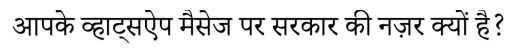

Image: /kaggle/input/hindi-ocr-synthetic-line-image-text-pair/data_80k/output_images/16.png
Generated Text: आपके व्हाट्सऐप मैसेज पर सरकार की नज़र क्यों है?
-------------------------xxxx-------------------------


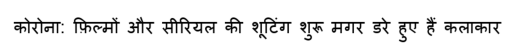

Image: /kaggle/input/hindi-ocr-synthetic-line-image-text-pair/data_80k/output_images/17.png
Generated Text: कोरोना : फ़िल्मों और सीरियल की शूटिंग शुरू मगर डरे हुए हैं कलाकार
-------------------------xxxx-------------------------


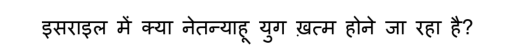

Image: /kaggle/input/hindi-ocr-synthetic-line-image-text-pair/data_80k/output_images/18.png
Generated Text: इसराइल में क्या नेतन्याहू युग ख़त्म होने जा रहा है?
-------------------------xxxx-------------------------


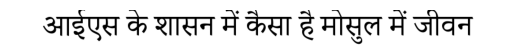

Image: /kaggle/input/hindi-ocr-synthetic-line-image-text-pair/data_80k/output_images/19.png
Generated Text: आईएस के शासन में कैसा है मोसुल में जीवन
-------------------------xxxx-------------------------


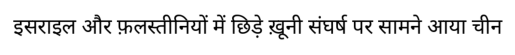

Image: /kaggle/input/hindi-ocr-synthetic-line-image-text-pair/data_80k/output_images/20.png
Generated Text: इसराइल और फ़लस्तीनियों में छिड़े ख़ूनी संघर्ष पर सामने आया चीन
-------------------------xxxx-------------------------


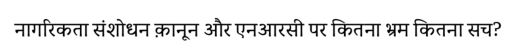

Image: /kaggle/input/hindi-ocr-synthetic-line-image-text-pair/data_80k/output_images/21.png
Generated Text: नागरिकता संशोधन क़ानून और एनआरसी पर कितना भ्रम कतना सच?
-------------------------xxxx-------------------------


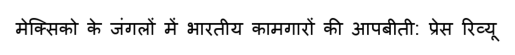

Image: /kaggle/input/hindi-ocr-synthetic-line-image-text-pair/data_80k/output_images/22.png
Generated Text: मेक्सिको के जंगलों में भारतीय कामगारों की आपबीती : प्रेस रिव्यू
-------------------------xxxx-------------------------


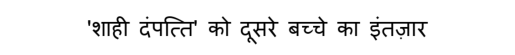

Image: /kaggle/input/hindi-ocr-synthetic-line-image-text-pair/data_80k/output_images/23.png
Generated Text: ' शाही दंपत्ति'को दूसरे बच्चे का इंतज़ार
-------------------------xxxx-------------------------


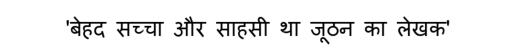

Image: /kaggle/input/hindi-ocr-synthetic-line-image-text-pair/data_80k/output_images/24.png
Generated Text: ' बेहद सच्चा और साहसी था जूठन का लेखक '
-------------------------xxxx-------------------------


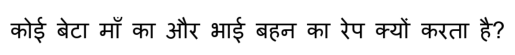

Image: /kaggle/input/hindi-ocr-synthetic-line-image-text-pair/data_80k/output_images/25.png
Generated Text: कोई बेटा माँ का और भाई बहन का रेप क्यों करता है?
-------------------------xxxx-------------------------


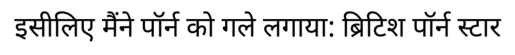

Image: /kaggle/input/hindi-ocr-synthetic-line-image-text-pair/data_80k/output_images/26.png
Generated Text: इसीलिए मैंने पॉर्न को गले लगाया : ब्रिटिश पॉन्न स्टार
-------------------------xxxx-------------------------


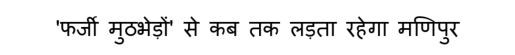

Image: /kaggle/input/hindi-ocr-synthetic-line-image-text-pair/data_80k/output_images/27.png
Generated Text: ' फर्जी मुठभेड़ों'से कब तक लड़ता रहेगा मणिपुर
-------------------------xxxx-------------------------


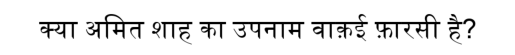

Image: /kaggle/input/hindi-ocr-synthetic-line-image-text-pair/data_80k/output_images/28.png
Generated Text: क्या अमित शाह का उपनाम वाक़ई फ़ारसी है?
-------------------------xxxx-------------------------


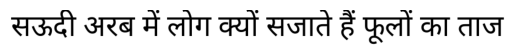

Image: /kaggle/input/hindi-ocr-synthetic-line-image-text-pair/data_80k/output_images/29.png
Generated Text: सऊदी अरब में लोग क्यों सजाते हैं फूलों का ताज
-------------------------xxxx-------------------------


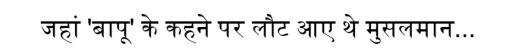

Image: /kaggle/input/hindi-ocr-synthetic-line-image-text-pair/data_80k/output_images/30.png
Generated Text: जहां'बापू'के कहने पर लौट आए थे मुसलमान...
-------------------------xxxx-------------------------


In [27]:
# Iterate over ten images
for i in range(1, 31):
    # Construct image path
    img_path = f"/kaggle/input/hindi-ocr-synthetic-line-image-text-pair/data_80k/output_images/{i}.png"

    # Read and display image
    img = Image.open(img_path)
    plt.imshow(img)
    plt.axis('off')
    plt.show()

    # Tokenize and preprocess image
    transform = v2.Compose([
        v2.Resize((384,384)),
        v2.ToTensor(),
        v2.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5]),
    ])
    img_t = transform(img).unsqueeze(0)
    p= img_t.to(device)

    # Generate text
    generated_ids = model.generate(p)
    generated_text = processor.batch_decode(generated_ids, skip_special_tokens=True)[0]

    # Print generated text
    print(f"Image: {img_path}")
    print(f"Generated Text: {generated_text}")
    print("-------------------------xxxx-------------------------")

## Hope you like my work, please do upvote 😊